This notebook explains the process of applying cuts and selection criteria.

In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

In [2]:
#importing waveform files 
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T000810Z_tier_raw.lh5'

In [3]:
#importing JSON file which describes each detector 
f = open('channel_maps.json','r')
cmap = json.load(f)

In [4]:
target_bege = "bege"

# Iterate through cmap to find the key for the desired_type
matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
# Character to add
ch = "ch"

# Use list comprehension to add ch to each element in the array
detectors_bege = [ch+element for element in matching_bege]

**Initial Imports**

In this section I import all the data and form dictionaries so the data can easily be acsessed throughout the notebook.

In [6]:
tb_data_dict = {}  # Dictionary to store tb_data for each detector
wfs_all_dict = {}  # Dictionary to store waveforms for each detector

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

**Minimum value determination**

Determining the minimum values of the waveforms.

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]
    
    # Initialize empty lists to store min and max values
    min_values = []
    
    # Loop through all waveforms to find the min values
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0) #min of current waveform 
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

**Initial cuts**

Discharges typically have a smaller minimum value than calibration events and hence it is easier to remove baselines and testing data.

In [9]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    # Calculate Z-scores for the minimum values
    min_z_scores = zscore(min_values)
    
    # Initialise empty lists to store filtered and skipped min values, as well as their corresponding indices
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    # Loop through Z-scores and filter out anomalies
    for i, z_score in enumerate(min_z_scores):
        # Check if the Z-score for the min value is beyond the threshold
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            # If beyond the threshold, skip this iteration
            continue
        
        # Append the min value to the filtered list
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [10]:
threshold = 1 #one standard deviation
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

Introducing a parameter which will tell how many waveforms were correctly removed.

Another cut but now for the maximal value 

In [11]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    # Loop through all waveforms to find the max values
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        max_values.append(wf_max)
    
    return max_values

In [12]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [13]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    # Calculate Z-scores for the maximum values
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    # Initialise empty lists to store filtered and skipped max values, as well as their corresponding indices
    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    # Loop through Z-scores and filter out anomalies
    for i, z_score in enumerate(max_z_scores):
        # Check if the Z-score for the max value is beyond the threshold
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            # If beyond the threshold, skip this iteration
            continue
        
        # Append the max value to the filtered list
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

Here we have added in another selection criteria. Essentially what this means is if the length of the 1st cut is smaller than 20 we dont proceed with the next cut. 
This is done such that if the first cut was sufficient ie we had extracted all of the discharges in the first cut then the second would be too much ie it would remove incorrect waveforms. 

In [14]:
threshold =1 #1 standard deviation 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20: #
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

This detector ch1107202 doesn't have any discharges
Skipped waveforms for detector ch1110402: [1130, 1177, 1361]
Percentage of discharges present: 0.21246458923512845%


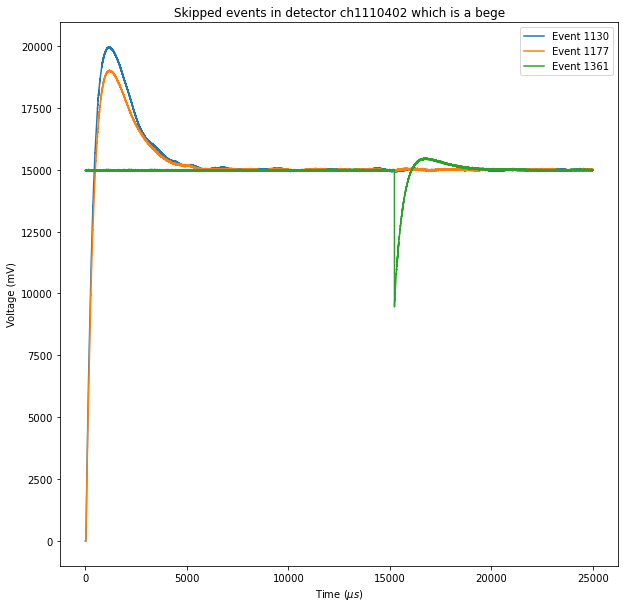

Skipped waveforms for detector ch1110403: [51, 393]
Percentage of discharges present: 0.14164305949008194%


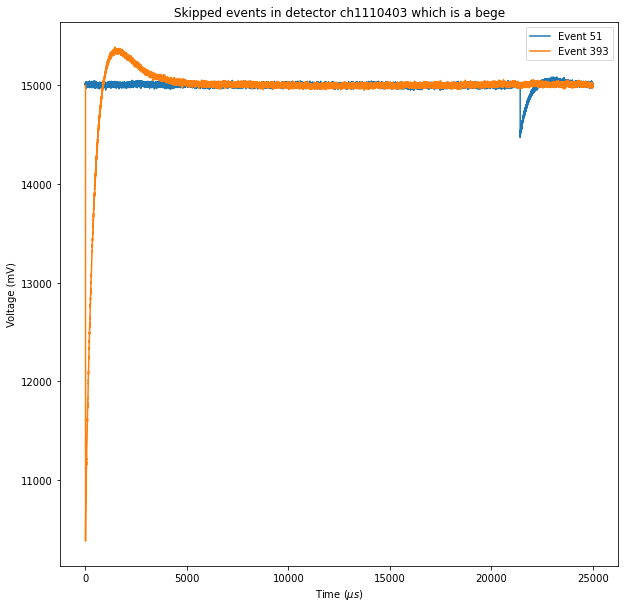

This detector ch1112005 doesn't have any discharges
Skipped waveforms for detector ch1113600: [37, 88, 130, 467, 827, 962, 1317]
Percentage of discharges present: 0.4957507082152923%


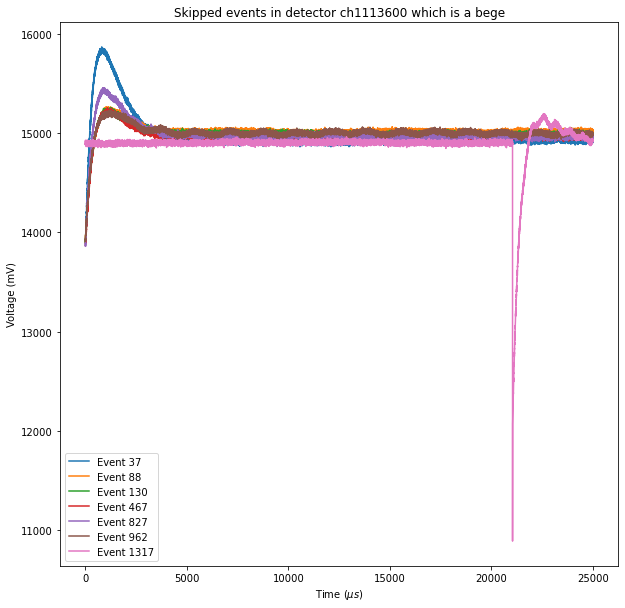

Skipped waveforms for detector ch1113601: [37, 88, 130, 467, 858, 962]
Percentage of discharges present: 0.4249291784702569%


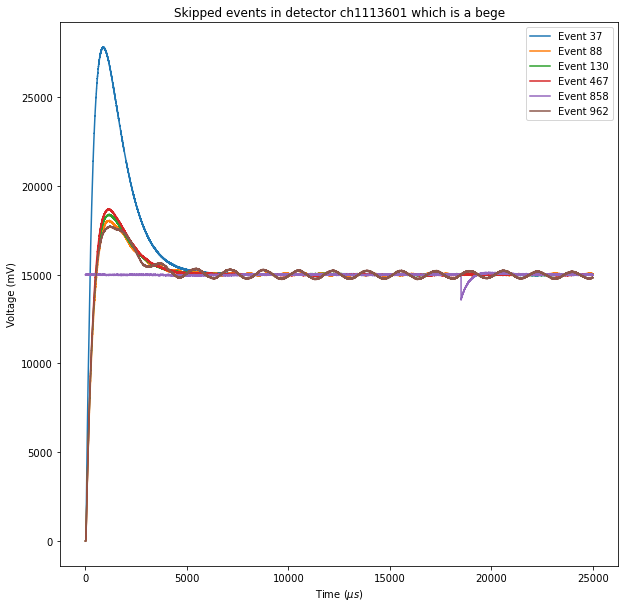

Skipped waveforms for detector ch1113602: [139, 858, 978, 1265, 1272, 1292]
Percentage of discharges present: 0.4249291784702569%


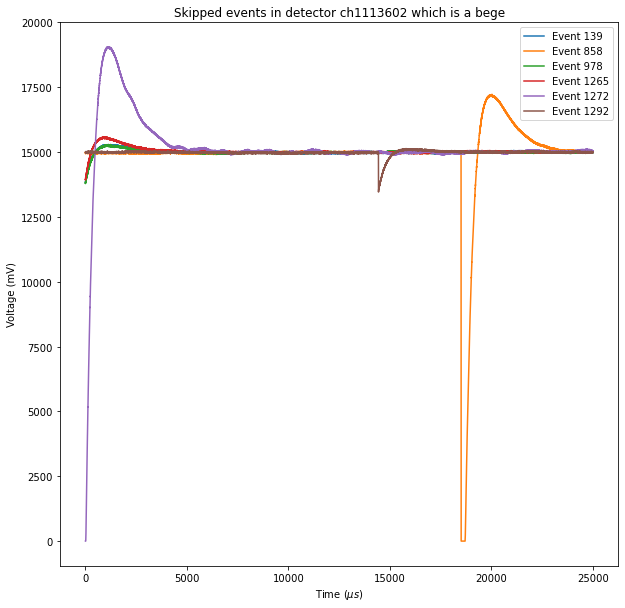

Skipped waveforms for detector ch1113603: [139, 978]
Percentage of discharges present: 0.14164305949008194%


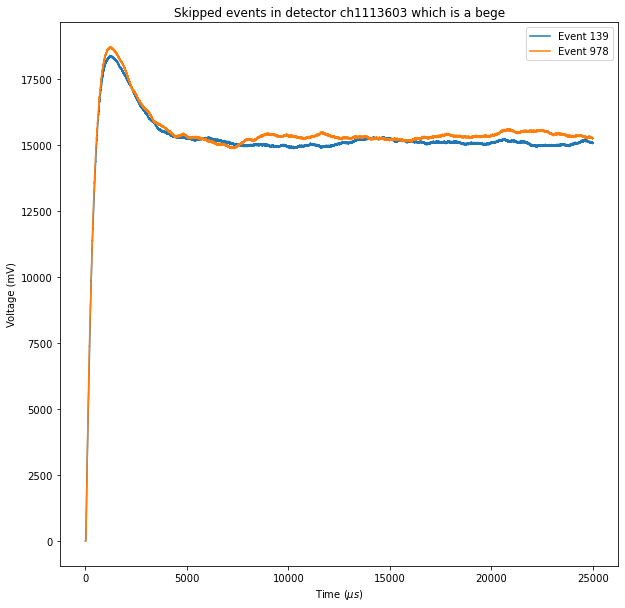

Skipped waveforms for detector ch1113604: [514, 1161]
Percentage of discharges present: 0.14164305949008194%


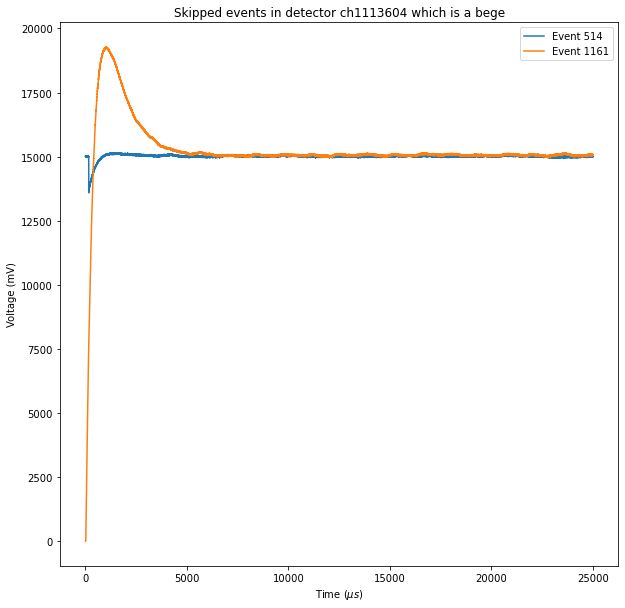

This detector ch1113605 doesn't have any discharges
Skipped waveforms for detector ch1120003: [62, 210, 456, 478, 532, 546, 672, 982, 1200, 1405]
Percentage of discharges present: 0.7082152974504208%


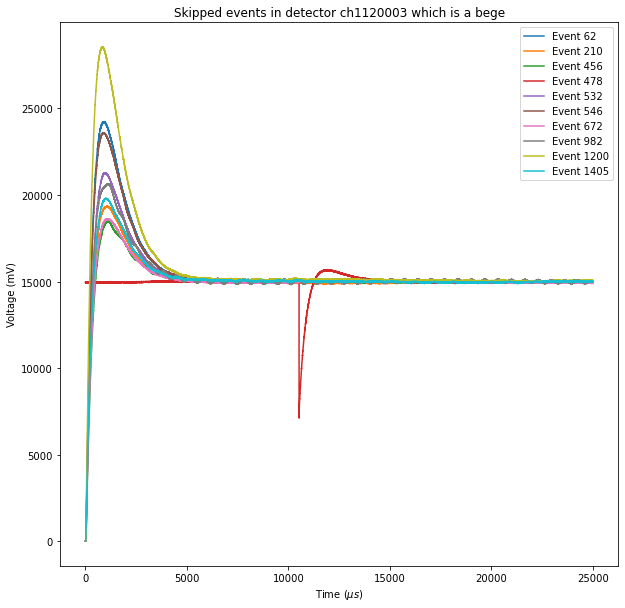

Skipped waveforms for detector ch1120004: [389, 397, 761, 1227]
Percentage of discharges present: 0.283286118980175%


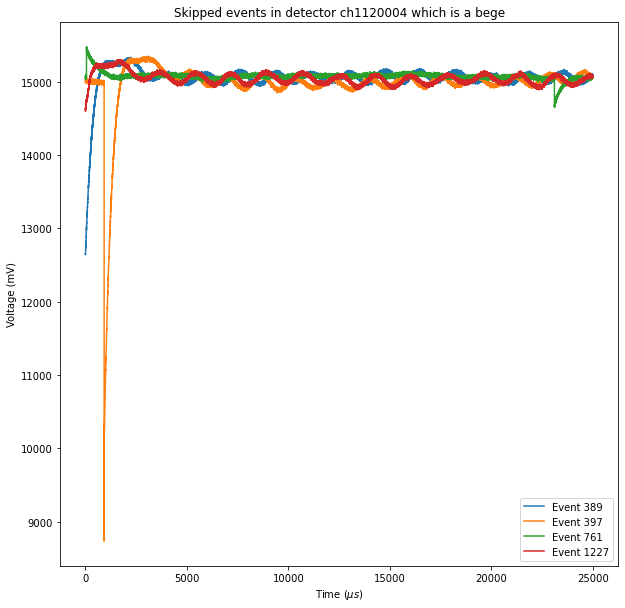

This detector ch1078405 doesn't have any discharges
Skipped waveforms for detector ch1080000: [494, 501, 1097, 1303]
Percentage of discharges present: 0.283286118980175%


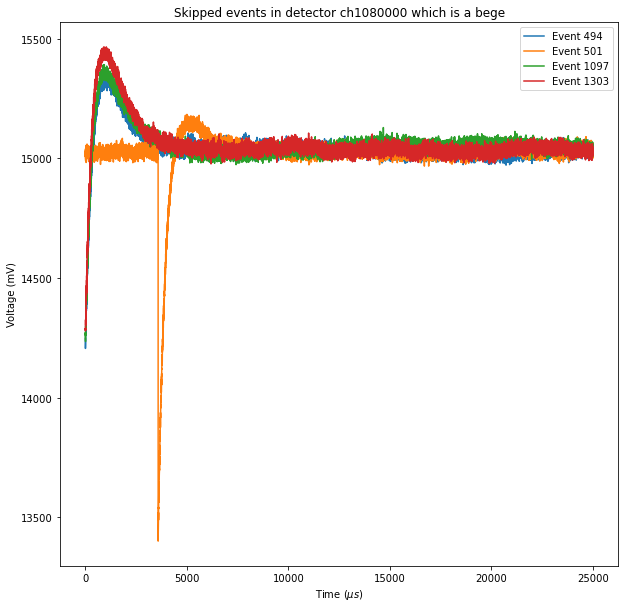

Skipped waveforms for detector ch1080001: [494, 1097, 1303]
Percentage of discharges present: 0.21246458923512845%


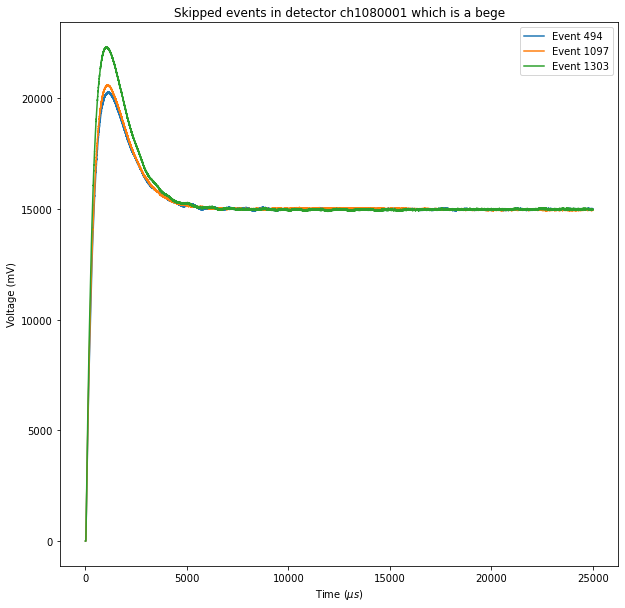

This detector ch1080002 doesn't have any discharges
This detector ch1083200 doesn't have any discharges
Skipped waveforms for detector ch1083201: [85, 430, 448, 506, 850, 906, 1094]
Percentage of discharges present: 0.4957507082152923%


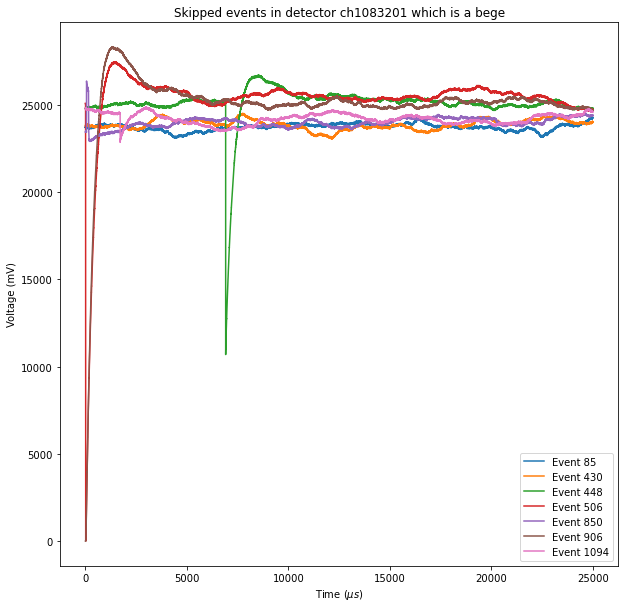

Skipped waveforms for detector ch1083202: [474, 506, 1160, 1402]
Percentage of discharges present: 0.283286118980175%


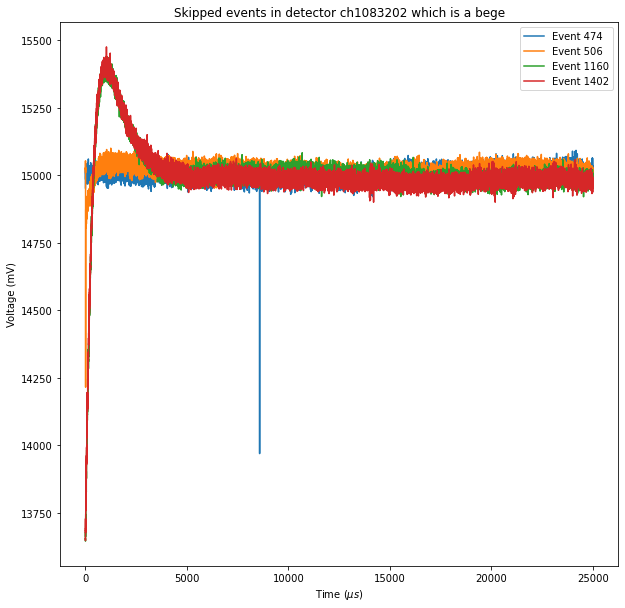

Skipped waveforms for detector ch1083203: [32, 437, 573, 1160, 1224, 1402]
Percentage of discharges present: 0.4249291784702569%


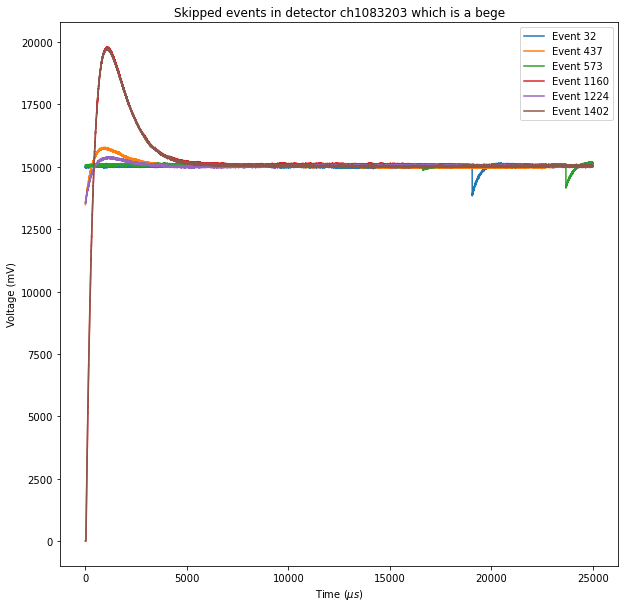

Skipped waveforms for detector ch1083204: [437, 474, 1224]
Percentage of discharges present: 0.21246458923512845%


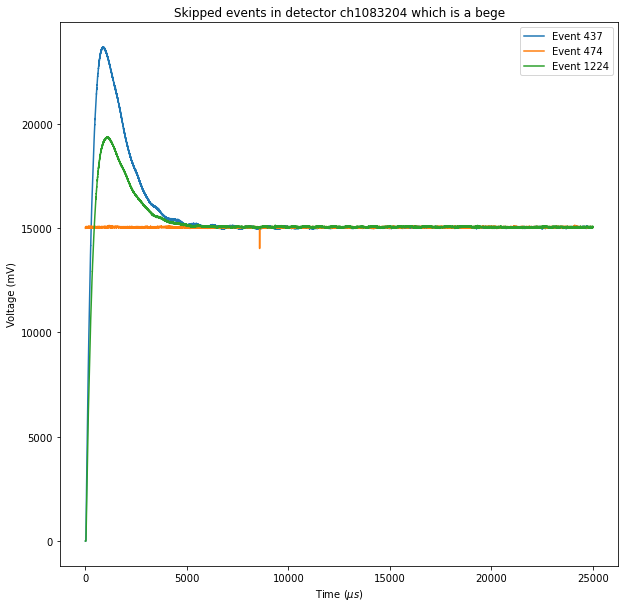

Skipped waveforms for detector ch1083205: [408, 474, 506, 1313]
Percentage of discharges present: 0.283286118980175%


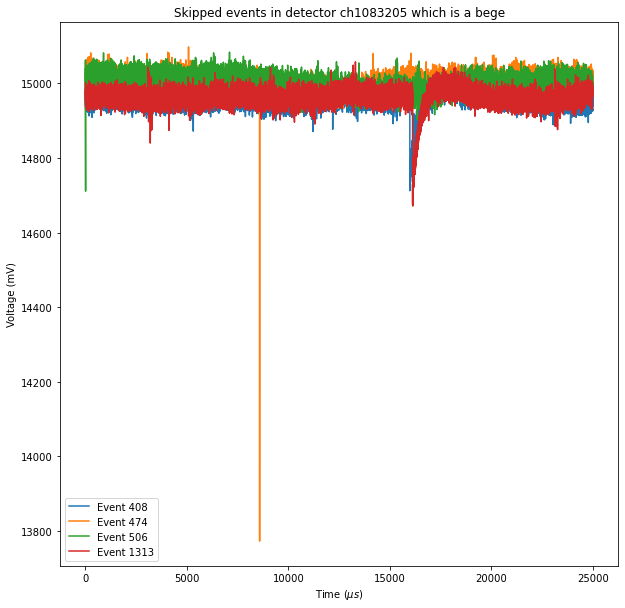

Skipped waveforms for detector ch1084800: [408, 444, 474, 481, 1129]
Percentage of discharges present: 0.3541076487252104%


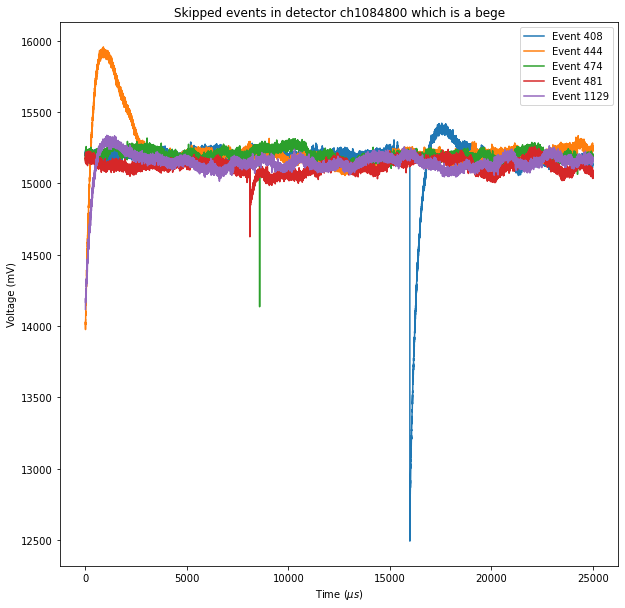

Skipped waveforms for detector ch1084801: [444, 474, 481, 791, 1129]
Percentage of discharges present: 0.3541076487252104%


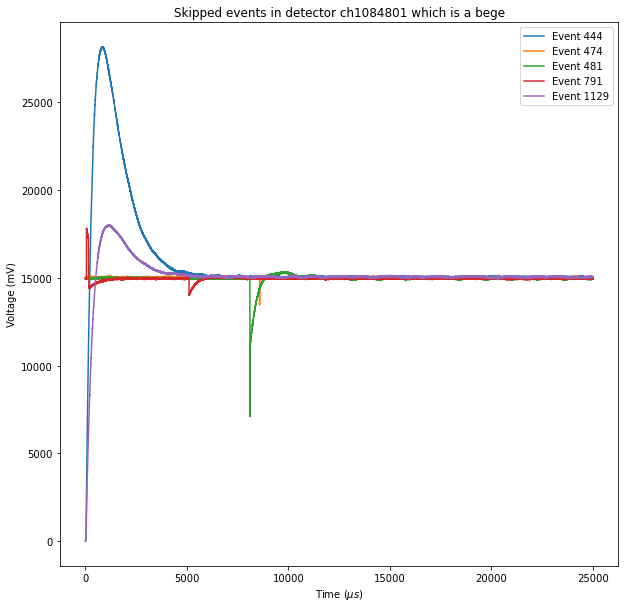

Skipped waveforms for detector ch1084802: [474, 495]
Percentage of discharges present: 0.14164305949008194%


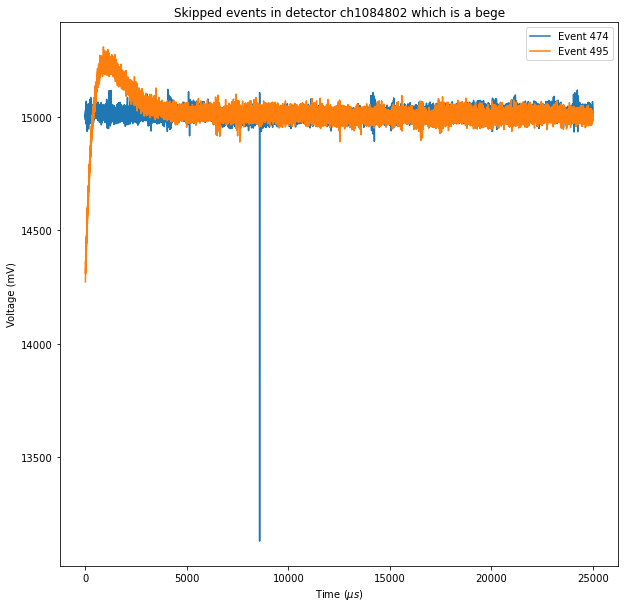

This detector ch1086403 doesn't have any discharges
This detector ch1086404 doesn't have any discharges
Skipped waveforms for detector ch1086405: [163]
Percentage of discharges present: 0.07082152974504652%


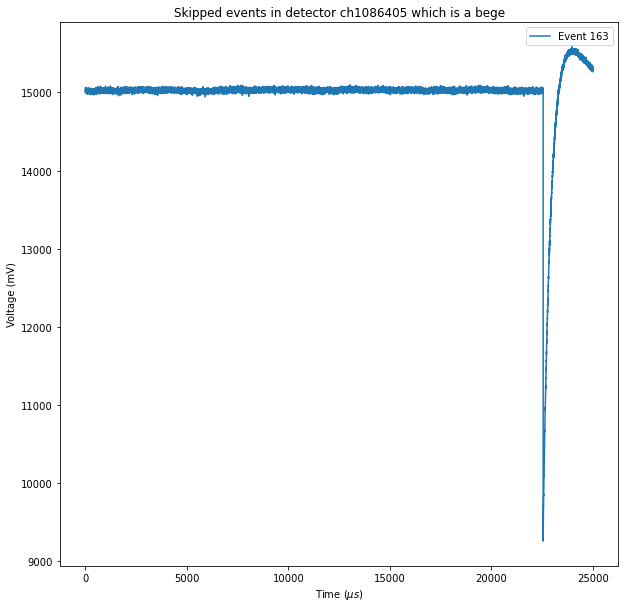

In [15]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    #another cut which suggests that if the data set is more than 20 the

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1  # Store all skipped indices for the detector
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform

        # Customize plot
        plt.xlabel('Time ($\mu s$)')
        plt.ylabel('Voltage (mV)')
        plt.title(f'Skipped events in detector {j} which is a {test}')
        plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")